In [7]:
RFTrackPath = '/home/pkruyt/cernbox/rf-track-2.0'
RFTrackPath = '/home/pkruyt/cernbox/rf-track-2.1.6'
import sys
import numpy as np
sys.path.append(RFTrackPath)

import RF_Track as RFT




In [8]:
# copyright ############################### #
# This file is part of the Xtrack Package.  #
# Copyright (c) CERN, 2021.                 #
# ######################################### #


import ducktrack as dtk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from tqdm import tqdm

import xtrack as xt
import xobjects as xo
import xpart as xp


beta_rel = 0.305
#beta_rel = 0.106

gamma = 1.050
#gamma = 1.006


current=2.4
cooler_length = 1.5 # m cooler length
r_beam=25*1e-3

mass0=938.27208816*1e6 #ev/c^2

T_perp = 100e-3 # <E> [eV] = kb*T
T_l =  1e-3 # <E> [eV]
magnetic_field = 0.060 # T for AD
B_ratio=1e-10



c=299792458.0

p0c = mass0*beta_rel*gamma #eV/c



circumference = 182.43280000000 #m
T = circumference/(c*beta_rel)
s_per_turn = T

print('sec_per_turn',s_per_turn)

alpha_x=0
alpha_y=0
Q_x=5.44
Q_y=5.42
DQx=0
DQy=0
momentum_compaction=0


beta_x=10 
beta_y=4

#disp_x=0.12
disp_x=0



arc = xt.LineSegmentMap(
        qx=Q_x, qy=Q_y, qs=0,
        bets = 1*1e40, length=circumference,
        betx=beta_x,
        bety=beta_y
        )


sec_per_turn 1.9951813726709976e-06


In [9]:
# twiss = np.array([length,beta_x, alpha_x, Q_x, beta_y, alpha_y, Q_y])
# transfer_line = RFT.TransferLine(twiss)

#% Crate one matching transfer matrix for the rest of the ring
twiss = np.zeros((2, 11))
twiss[0,:] = [ 0, beta_x, 0, 0,  beta_y, 0, 0 , 0, 0, 0, 0]; #% cooler end
twiss[1,:] = [ circumference, beta_x,  0, Q_x, beta_y,  0, Q_y, 0, 0, 0, 0]; #% cooler start

transfer_line = RFT.TransferLine(twiss, 0, 0, 0, p0c*1e-6)


In [10]:
num_particles=1000
#old
emittance=35*1e-6 #inital emittance
emittance=5*1e-6 #inital emittance

sigma_x = np.sqrt(beta_x*emittance)
sigma_px = np.sqrt(emittance*1/beta_x)
sigma_y = np.sqrt(beta_y*emittance)
sigma_py = np.sqrt(emittance*1/beta_y)
sigma_p = 5e-4

delta = np.random.normal(loc=0.0, scale=sigma_p,  size=num_particles)
x =     np.random.normal(loc=0.0, scale=sigma_x,  size=num_particles)+disp_x*delta
px =    np.random.normal(loc=0.0, scale=sigma_px, size=num_particles)
y =     np.random.normal(loc=0.0, scale=sigma_y,  size=num_particles)
py =    np.random.normal(loc=0.0, scale=sigma_py, size=num_particles)

t= np.random.normal(loc=0.0, scale=0.0, size=num_particles)
p = delta*p0c+p0c

particles = xp.Particles(
        
        mass0=mass0,
        q0=1,
        p0c=p0c,
        x=x,
        px=px,
        y=y,
        py=py,
        delta=delta,
        zeta=0)



###########################################################################################################
from Xsuite_to_RF import XSUITE_TO_RF_converter
from RF_to_Xsuite import RF_TO_XSUITE_converter

beam=XSUITE_TO_RF_converter(particles)

# beam.set_coasting()

#B = RFT.Bunch6d(mass0, num_particles, 1, [x,px,y,py,t, p] )


In [11]:
cooler = xt.ElectronCooler(current=current,length=cooler_length,r_beam=r_beam,
                                         T_perp=T_perp,T_l=T_l,
                                         magnetic_field=magnetic_field,B_ratio=B_ratio,
                                         Neutralisation_space_charge=0)
Nx = 20
Ny = 20
Nz = 10


ne=8.343768e+13 # e/m^3
# ne=0
Cooler_Vele=beta_rel

E = RFT.ElectronCooler(cooler_length, r_beam, r_beam,ne,Cooler_Vele)
E.set_Q(-1); #% electron charge
E.set_static_Bfield(0.0, 0.0, magnetic_field)
E.set_temperature(T_perp, T_l)
#E.set_electron_mesh(Nx, Ny, Nz, ne, 0, 0, Cooler_Vele)

In [12]:
num_turns =int(3e6)
# Define the save interval
save_interval = 1000

# Create empty lists to store RF track data
x_rf_list = []
px_rf_list = []
y_rf_list = []
py_rf_list = []
action_x_rf_list = []
emittance_x_rf_list = []
emittance_y_rf_list = []
emitt_4d_list = []

# Create empty lists to store data
x_xs_list = []
px_xs_list = []
y_xs_list = []
py_xs_list = []
action_x_xs_list = []
action_y_xs_list = []
emittance_x_xs_list = []
emittance_y_xs_list = []


# progress_bar = tqdm(total=num_turns)
# progress_bar2 = tqdm(total=num_turns)

# Perform the loop
for i in tqdm(range(num_turns),leave='False'):
    #progress_bar.update(1)

    I = beam.get_info()
    x_rf = beam.get_phase_space("%x") * 1e-3
    px_rf = beam.get_phase_space("%xp") * 1e-3
    y_rf = beam.get_phase_space("%y") * 1e-3
    py_rf = beam.get_phase_space("%yp") * 1e-3
    emitt_rf = I.emitt_4d * 1e-6

    action_x_temp = (x_rf ** 2 / beta_x + beta_x * px_rf ** 2)
    
    cov00_x = np.cov(x_rf.flatten()[1::], px_rf.flatten()[1::])
    det00_x = np.sqrt(np.linalg.det(cov00_x)) * beta_rel * gamma

    cov00_y = np.cov(y_rf.flatten()[1::], py_rf.flatten()[1::])
    det00_y = np.sqrt(np.linalg.det(cov00_y)) * beta_rel * gamma

    if i % save_interval == 0:
        x_rf_list.append(x_rf.flatten()[1::])
        px_rf_list.append(px_rf.flatten()[1::])
        y_rf_list.append(y_rf.flatten()[1::])
        py_rf_list.append(py_rf.flatten()[1::])
        action_x_rf_list.append(action_x_temp.flatten()[1::])
        emittance_x_rf_list.append(det00_x)
        emittance_y_rf_list.append(det00_y)
        emitt_4d_list.append(emitt_rf)

    if 0:
        transfer_line.track(beam)
        E.track(beam)
    else:
        L = RFT.Lattice()
        L.append(transfer_line)
        L.append(E)
        beam = L.track(beam)



# Perform the loop
for i in tqdm(range(num_turns),leave='False'):
    #progress_bar2.update(1)

    x_xs = particles.x.copy()
    px_xs = particles.px.copy()
    y_xs = particles.y.copy()
    py_xs = particles.py.copy()

    action_x_temp = (x_xs ** 2 / beta_x + beta_x * px_xs ** 2)

    cov00 = np.cov(x_xs, px_xs)
    det00 = np.sqrt(np.linalg.det(cov00)) * beta_rel * gamma

    cov01 = np.cov(y_xs, py_xs)
    det01 = np.sqrt(np.linalg.det(cov01)) * beta_rel * gamma

    if i % save_interval == 0:
        x_xs_list.append(x_xs)
        px_xs_list.append(px_xs)
        y_xs_list.append(y_xs)
        py_xs_list.append(py_xs)
        action_x_xs_list.append(action_x_temp)
        emittance_x_xs_list.append(det00)
        emittance_y_xs_list.append(det01)

    arc.track(particles)
    cooler.track(particles)

time = np.arange(0, num_turns, save_interval) * s_per_turn

  0%|          | 0/3000000 [00:00<?, ?it/s]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


  0%|          | 169/3000000 [00:05<20:07:55, 41.39it/s]

Done compiling ContextCpu kernels.


100%|██████████| 3000000/3000000 [26:56<00:00, 1856.29it/s]


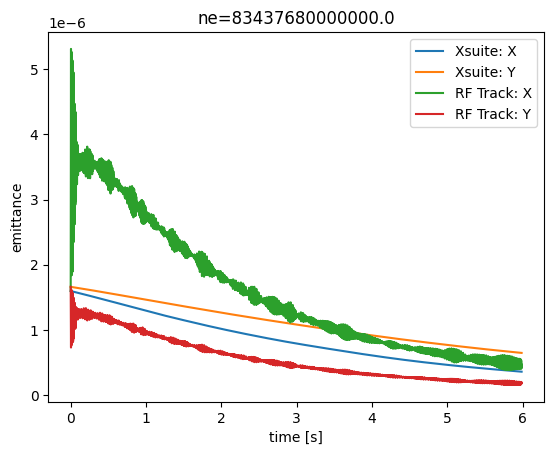

In [13]:
# plt.figure()
# plt.title('action vs turns')
# plt.plot(action_x_rf_list,label='RF Track')
# plt.plot(action_x_xs_list,label='Xsuite')
# plt.xlabel('turns')
# plt.ylabel('$J_x$')
# plt.legend()
# plt.show()

plt.figure()
#plt.plot(emittance_rf_list,label='RF Track')
# plt.title(f'ne={ne}')
plt.plot(time,emittance_x_xs_list,label='Xsuite: X')
plt.plot(time,emittance_y_xs_list,label='Xsuite: Y')
#plt.plot(time,emitt_4d_list,label='RF Track: emitt 4d')
plt.plot(time,emittance_x_rf_list,label='RF Track: X')
plt.plot(time,emittance_y_rf_list,label='RF Track: Y')
plt.xlabel('time [s]')
plt.ylabel('emittance')
plt.legend()
plt.show()



In [14]:
np.savez('emittance_xs(current).npz', time=time, emittance_x=emittance_x_xs_list,emittance_y=emittance_y_xs_list)
np.savez('emittance_rf(current).npz', time=time, emittance=emitt_4d_list)

In [15]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Create subplots for x
# fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

# # Plot RF Track for x
# ax1.plot(x_rf_list)
# ax1.set_title('RF Track (x)')
# ax1.set_xlabel('turns')
# ax1.set_ylabel('x [m]')

# # Plot Xsuite for x
# ax2.plot(x_xs_list)
# ax2.set_title('Xsuite (x)')
# ax2.set_xlabel('turns')
# ax2.set_ylabel('x [m]')

# # Calculate the difference array for x
# xs_array = np.array(x_xs_list)
# rf_array = np.array(x_rf_list)
# difference_array = xs_array - rf_array

# # Plot the difference array for x
# ax3.plot(difference_array)
# ax3.set_title('Difference (x)')
# ax3.set_xlabel('turns')
# ax3.set_ylabel('x [m]')

# # Adjust spacing between subplots for x
# plt.tight_layout()
# fig.subplots_adjust(hspace=0.5)
# fig.subplots_adjust(top=0.85)

# # Create subplots for px
# fig2, (ax4, ax5, ax6) = plt.subplots(3, 1, figsize=(10, 10))

# # Plot RF Track for px
# ax4.plot(px_rf_list)
# ax4.set_title('RF Track (px)')
# ax4.set_xlabel('turns')
# ax4.set_ylabel('px [m]')

# # Plot Xsuite for px
# ax5.plot(px_xs_list)
# ax5.set_title('Xsuite (px)')
# ax5.set_xlabel('turns')
# ax5.set_ylabel('px [m]')

# # Calculate the difference array for px
# px_xs_array = np.array(px_xs_list)
# px_rf_array = np.array(px_rf_list)
# px_difference_array = px_xs_array - px_rf_array

# # Plot the difference array for px
# ax6.plot(px_difference_array)
# ax6.set_title('Difference (px)')
# ax6.set_xlabel('turns')
# ax6.set_ylabel('px [m]')

# # Adjust spacing between subplots for px
# plt.tight_layout()
# fig2.subplots_adjust(hspace=0.5)
# fig2.subplots_adjust(top=0.85)

# # Display the figures
# plt.show()


In [16]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Create subplots for y
# fig1, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

# # Plot RF Track for y
# ax1.plot(y_rf_list)
# ax1.set_title('RF Track (y)')
# ax1.set_xlabel('turns')
# ax1.set_ylabel('y [m]')

# # Plot Xsuite for y
# ax2.plot(y_xs_list)
# ax2.set_title('Xsuite (y)')
# ax2.set_xlabel('turns')
# ax2.set_ylabel('y [m]')

# # Calculate the difference array for y
# y_xs_array = np.array(y_xs_list)
# y_rf_array = np.array(y_rf_list)
# y_difference_array = y_xs_array - y_rf_array

# # Plot the difference array for y
# ax3.plot(y_difference_array)
# ax3.set_title('Difference (y)')
# ax3.set_xlabel('turns')
# ax3.set_ylabel('y [m]')

# # Adjust spacing between subplots for y
# plt.tight_layout()
# fig1.subplots_adjust(hspace=0.5)
# fig1.subplots_adjust(top=0.85)

# # Create subplots for py
# fig2, (ax4, ax5, ax6) = plt.subplots(3, 1, figsize=(10, 10))

# # Plot RF Track for py
# ax4.plot(py_rf_list)
# ax4.set_title('RF Track (py)')
# ax4.set_xlabel('turns')
# ax4.set_ylabel('py [m]')

# # Plot Xsuite for py
# ax5.plot(py_xs_list)
# ax5.set_title('Xsuite (py)')
# ax5.set_xlabel('turns')
# ax5.set_ylabel('py [m]')

# # Calculate the difference array for py
# py_xs_array = np.array(py_xs_list)
# py_rf_array = np.array(py_rf_list)
# py_difference_array = py_xs_array - py_rf_array

# # Plot the difference array for py
# ax6.plot(py_difference_array)
# ax6.set_title('Difference (py)')
# ax6.set_xlabel('turns')
# ax6.set_ylabel('py [m]')

# # Adjust spacing between subplots for py
# plt.tight_layout()
# fig2.subplots_adjust(hspace=0.5)
# fig2.subplots_adjust(top=0.85)

# # Display the figures
# plt.show()
